# CS4100 Final Project: Image Classification using Convolutional Neural Network

For this project, our goal is to classify different images of agricultural crops using our knowledge on convolutional neural networks (CNN). The dataset is imported from Kaggle using the Kaggle API. 

Source: https://www.kaggle.com/code/leekahwin/crops-image-cnn-vs-transfer-learning/input

Names: Ji Yoon (Angela) Rhee, Ruiming Li 

Recording: https://drive.google.com/file/d/1j4v7vkojCpfvs8SUaJQDQjAtLIisfxmL/view?usp=sharing 

Each person in the group collaborated on this project by taking turns writing code, fixing bugs, and finding resources. We met up on multiple occasions in an empty classroom on campus. 




In [ ]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import matplotlib.patches as mpatches

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import shutil
from shutil import copyfile

In [ ]:
import torch
from tqdm import trange

### Importing dataset from Kaggle using API:

In [ ]:
! pip install -q kaggle

In [ ]:
files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mdwaquarazam/agricultural-crops-image-classification

100% 79.0M/79.0M [00:01<00:00, 101MB/s] 
100% 79.0M/79.0M [00:01<00:00, 79.1MB/s]


In [ ]:
! mkdir agricultural-crops-image-classification 

! unzip agricultural-crops-image-classification.zip -d agricultural-crops-image-classification 

### Exploring our data

Now that we have downloaded and unzipped our dataset, we will take some time to explore what our data folder entices.

In [ ]:
import os

#setting a separate variable to store the name of the root directory
root_dir = '/content/agricultural-crops-image-classification/Agricultural-crops'

#listing the names of directories (this will be our label names): 
directories_list = os.listdir(root_dir)

#getting the number of labels:
num_labels = len(directories_list)
print(f"Total Class labels = {num_labels}")

print(directories_list)


Total Class labels = 30
['mustard-oil', 'soyabean', 'Cucumber', 'Lemon', 'Coffee-plant', 'tomato', 'Pearl_millet(bajra)', 'cotton', 'chilli', 'papaya', 'wheat', 'sugarcane', 'banana', 'almond', 'maize', 'clove', 'cardamom', 'sunflower', 'Fox_nut(Makhana)', 'pineapple', 'coconut', 'jute', 'rice', 'gram', 'Olive-tree', 'jowar', 'Tobacco-plant', 'tea', 'vigna-radiati(Mung)', 'Cherry']


Now that we have the sub-directories that contain the images, we want to display some sample images from each directory.

In [ ]:

images = []; labels = []
num_file_list = []; label_list = []

for folder in directories_list:
    #getting each label directory
    curr_fold_dir = os.path.join(root_dir, folder)
    #getting list of images of each label
    curr_fold_image = os.listdir(curr_fold_dir)
    #getting number of images per label
    curr_folder_size = len(os.listdir(curr_fold_dir))
    
    num_file_list.append(curr_folder_size)
    label_list.append(folder)
    
    #taking first image from each dir and display as a sample
    images.append(os.path.join(curr_fold_dir, curr_fold_image[0]))
    #adding label to label
    labels.append(folder)

#organizing the labels and the number of images 
#for each label into a dataframe
df_temp = pd.DataFrame({'Labels':label_list, 'Number of Images':num_file_list}).\
sort_values(by='Number of Images', ascending=False)
df_temp


Labels  Number of Images
6   Pearl_millet(bajra)                39
26        Tobacco-plant                33
29               Cherry                32
7                cotton                32
12               banana                31
2              Cucumber                31
14                maize                31
10                wheat                31
25                jowar                30
24           Olive-tree                30
1              soyabean                30
15                clove                30
4          Coffee-plant                29
22                 rice                29
0           mustard-oil                28
3                 Lemon                28
28  vigna-radiati(Mung)                27
5                tomato                26
20              coconut                25
23                 gram                25
11            sugarcane                25
19            pineapple                25
17            sunflower                24
18     Fox_nut(Makhana)                23
8                chilli                23
27                  tea                23
9                papaya                23
21                 jute                23
16             cardamom                22
13               almond                21

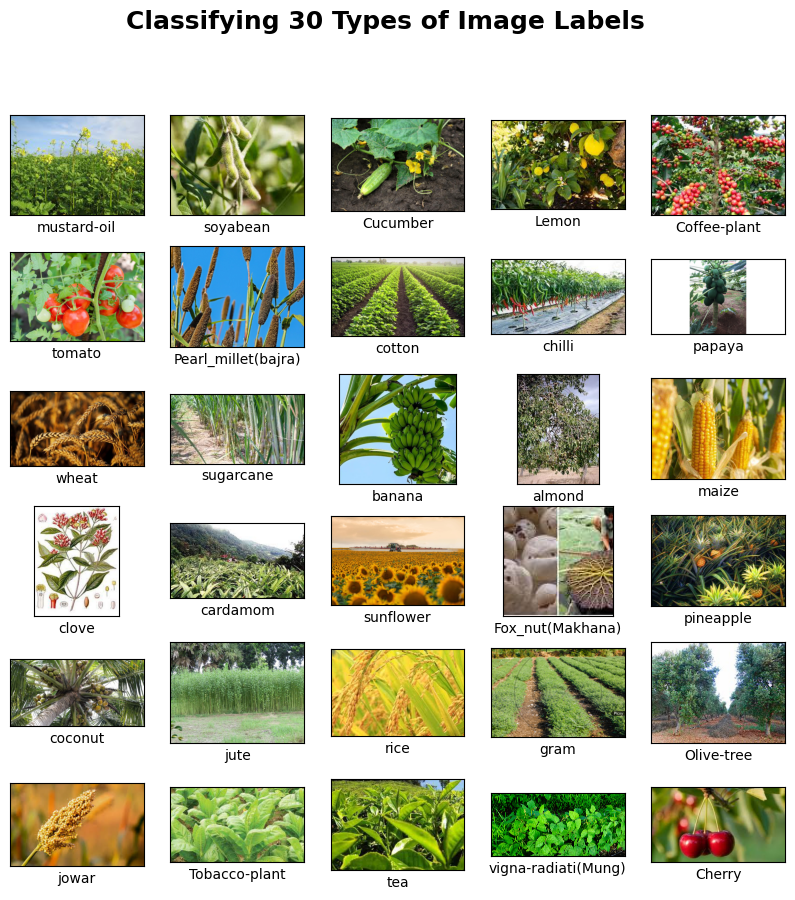

In [ ]:
#just as we did with MNIST dataset, we will use matplotlib to 
#diplay the sample images:
plt.figure(figsize=(10,10))
for i in range(len(images)):
    plt.subplot(6,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mpimg.imread(images[i])
    plt.imshow(img)
    plt.xlabel(labels[i])
    plt.suptitle(f"Classifying {num_labels} Types of Image Labels",fontsize=18, fontweight='bold')
plt.show()

After we explored our image data, we observed the following: 

- The images are not necessarily in the same dimensions as each other. 
- We only have 20-40 images to train our CNN model with, which can make our model prone to overfitting and affect the performance of the classification task. 
- We have larger number of classifying labels compared to the images. 
- The dataset has not been split for training and testing. 

Let us first do the dataset splitting first. Since we are directly accessing the images from the directories connected to this notebook, we decided to make our own random sampling function instead of using `train_test_split` function from Scikit-learn library.

In [ ]:
#our own train_test_split function we plan to use for this project:
def train_test_split(src_directory, train_directory, test_directory,
                     split_size):
  sampled_file_names = []
  all_file_names = os.listdir(src_directory)
  # i = 0

  for item in all_file_names:
    item_path = os.path.join(src_directory, item)
    item_size = os.path.getsize(item_path)

    #if the image file is not empty:
    if item_size != 0:
      #we sample this data
      sampled_file_names.append(item)
    #if empty
    else:
      #error catching
      print(f"{item} is empty, therefore we do not sample this image.")

    #setting a seed for random function 
    random.seed(38)

    #randomly select files for train 
    train = random.sample(sampled_file_names, int (split_size * len(sampled_file_names)))
    #every other pic not in train for testing 
    test  = [x for x in sampled_file_names if x not in train]

    #copying file path from src_directory into trainining  
  for pic in train: 
    source = os.path.join(src_directory, pic)
    destination = os.path.join(train_directory, pic)
    copyfile(source, destination)

    #copying file path from src_directory into testing 
  for pic in test: 
      source = os.path.join(src_directory, pic)
      destination = os.path.join(test_directory, pic)
      copyfile(source, destination)
    
  # print(f"{i}: Testing directory size = {len(test)}")
  # i = i + 1


In [ ]:
#in this function, we create two new directories that store
#sampled image files for training and testing purposes
def make_train_directory(root_path, split_size = 0.85): 
  for folder in directories_list: 
    source_dir = os.path.join(root_dir, folder)

    training_dir = os.path.join(root_path, f'_MODELLING/training/{folder}')
    validation_dir = os.path.join(root_path, f'_MODELLING/validation/{folder}')

    # Create EMPTY directory at the given directory paths
    os.makedirs(training_dir)
    os.makedirs(validation_dir)
        
    train_test_split(source_dir, training_dir, validation_dir, split_size)
    print("Created training and validation directories containing images at" + 
          f"split size of {split_size}")


In [ ]:
#we create the training and testing directories here: 
make_train_directory('/content/', split_size = 0.85)

0: Testing directory size = 5
0: Testing directory size = 5
0: Testing directory size = 5
0: Testing directory size = 5
0: Testing directory size = 5
0: Testing directory size = 4
0: Testing directory size = 6
0: Testing directory size = 5
0: Testing directory size = 4
0: Testing directory size = 4
0: Testing directory size = 5
0: Testing directory size = 4
0: Testing directory size = 5
0: Testing directory size = 4
0: Testing directory size = 5
0: Testing directory size = 5
0: Testing directory size = 4
0: Testing directory size = 4
0: Testing directory size = 4
0: Testing directory size = 4
0: Testing directory size = 4
0: Testing directory size = 4
0: Testing directory size = 5
0: Testing directory size = 4
0: Testing directory size = 5
0: Testing directory size = 5
0: Testing directory size = 5
0: Testing directory size = 4
0: Testing directory size = 5
0: Testing directory size = 5


To tackle the remaining issues we had with our original dataset, we now want to introduce the ``ImageDataGenerator`` class from Tensorflow library. The idea behind this class object is that it creates new variations of images at each epoch. Variations include rotation, width shifting, zooming in/out, and horizontal flips at different ranges. This helps us with having more images to train the model with at each epoch as well as fixing the dimensionality issues between each image files. 

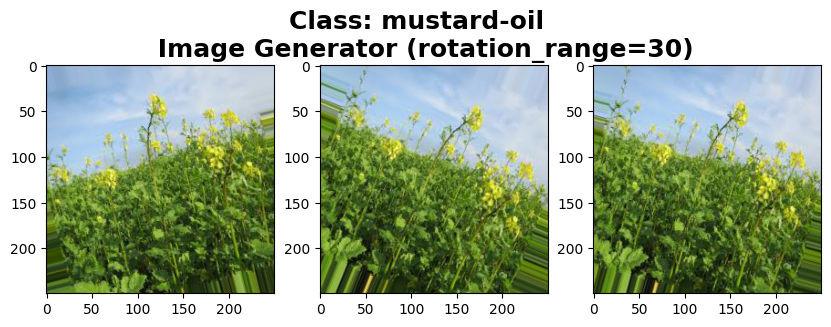

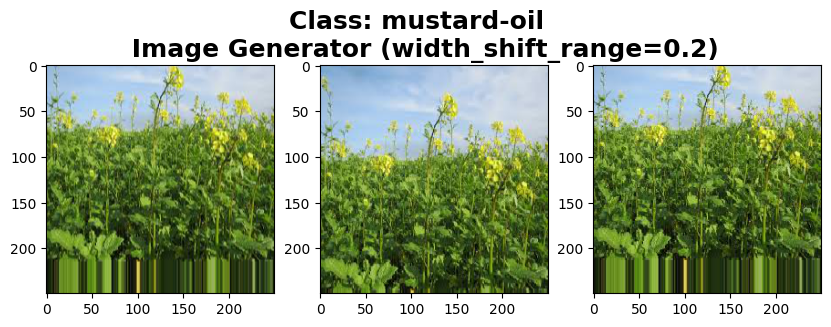

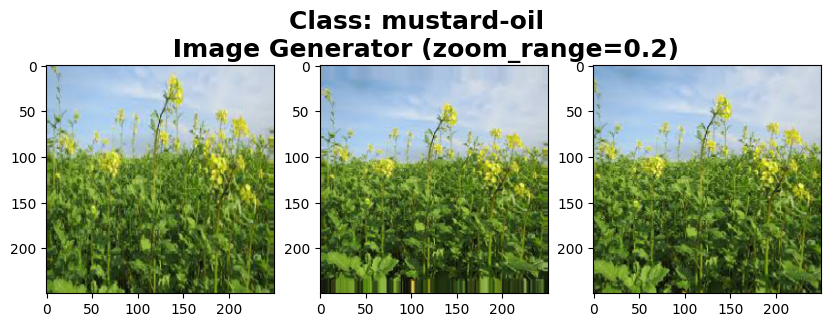

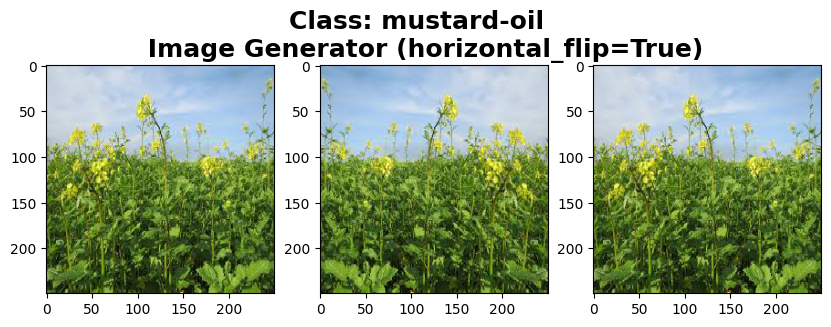

In [ ]:
def visualize_ImageDataGenerator(vis_images, vis_labels, image_index):
    #Loads image in from the set image path
    class_label = vis_labels[image_index]
    img = tf.keras.preprocessing.image.load_img(vis_images[image_index], target_size= (250,250))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    #Creates our batch of one image
    def show_image(datagen, param):
        pic = datagen.flow(img_tensor, batch_size =1)
        plt.figure(figsize=(10,3.5))
        #Plots our figures
        for i in range(1,4):
            plt.subplot(1, 3, i)
            batch = pic.next()
            image_ = batch[0].astype('uint8')
            plt.imshow(image_)
        plt.suptitle(f"Class: {class_label} \n Image Generator ({param})",
                     fontsize=18, fontweight='bold')

        plt.show()

    datagen = ImageDataGenerator(rotation_range=30)
    show_image(datagen, "rotation_range=30")

    datagen = ImageDataGenerator(width_shift_range=0.2)
    show_image(datagen, "width_shift_range=0.2")

    datagen = ImageDataGenerator(zoom_range=0.2)
    show_image(datagen, "zoom_range=0.2")

    datagen = ImageDataGenerator(horizontal_flip=True)
    show_image(datagen, "horizontal_flip=True")

visualize_ImageDataGenerator(images, labels, image_index = 0)


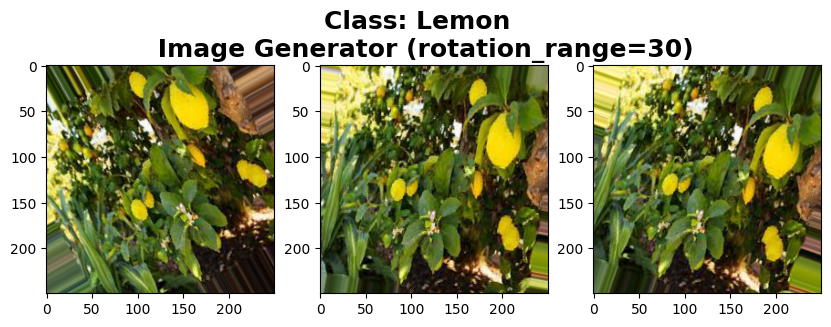

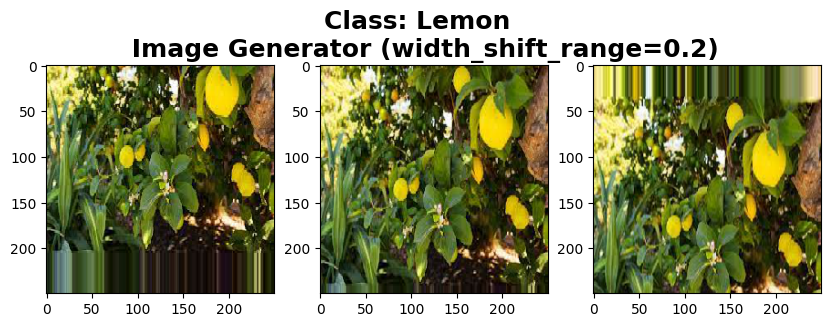

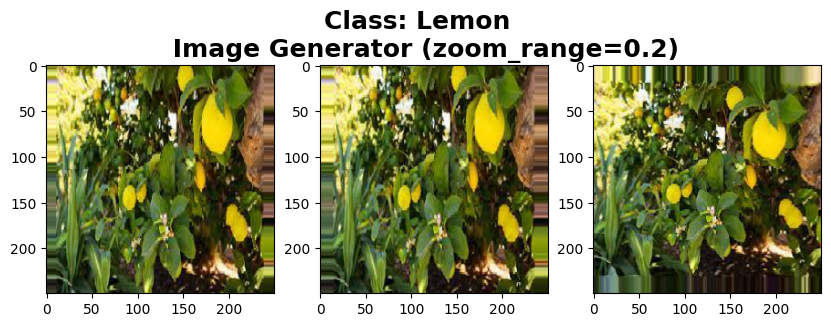

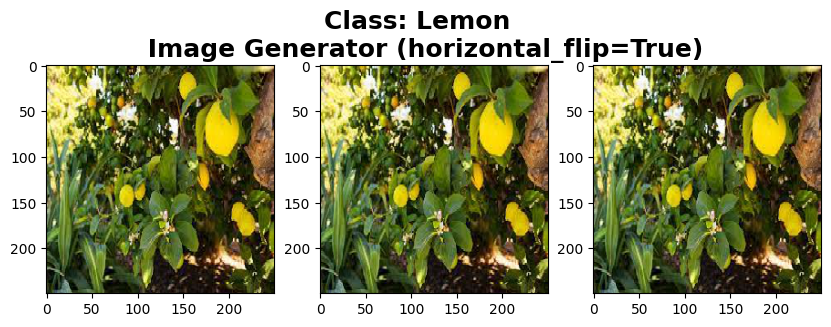

In [ ]:
visualize_ImageDataGenerator(images, labels, image_index = 3)

In [ ]:
def train_val_generators(training_dir, testing_dir):

    # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
    train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory=training_dir,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=testing_dir,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
    return train_generator, validation_generator

In [ ]:
training_dir = os.path.join('/content/', '_MODELLING', 'training') 
testing_dir = os.path.join('/content/', '_MODELLING', 'validation')

print(testing_dir)


/content/_MODELLING/validation


In [ ]:
train_generator, testing_generator = train_val_generators(training_dir, testing_dir)

Found 691 images belonging to 30 classes.
Found 138 images belonging to 30 classes.


### Implementing a Convolutional Neural Network:

We have taken the same DS4400 (machine learning) class, and we worked with CNNs using the MNIST dataset prior to this project. Inspired from that, we attempted to recreate the CNN using PyTorch as have done before.

In [ ]:
# input_size = 3 * 150 * 150  # input spatial dimension of images
# hidden_size = 512         # width of hidden layer
# output_size = num_labels          # number of output neurons

# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
# class CNN(torch.nn.Module):
    
#     def __init__(self):
        
#         super().__init__()
#         self.flatten = torch.nn.Flatten(start_dim=1)
#         self.conv1 = torch.nn.Conv2d(3, 3, kernel_size=3) # first convolutional layer
#         self.conv2 = torch.nn.Conv2d(3, 74, kernel_size=3) # second convolutional layer
#         self.max_pool1 = torch.nn.MaxPool2d(2)
#         self.max_pool2 = torch.nn.MaxPool2d(2)
#         self.fc = torch.nn.Linear(36*36*64, output_size) # third fully-connected layer
        
    
#     def forward(self, x):
#         # Input image is of shape [batch_size, 3, 150, 150]
#         # Need to flatten to [batch_size, 22500] before feeding to fc1
#         #x = self.flatten(x)

#         # ------------------  
#         x = self.conv1(x) 
#         x = torch.nn.functional.relu(x)
#         # x = self.max_pool1(x)
#         # x = torch.nn.functional.max_pool2d(x,2)
#         x = self.conv2(x) 
#         x = torch.nn.functional.relu(x)
#         # x = self.max_pool2(x)
#         # x = torch.nn.functional.max_pool2d(x,2)
#         x = torch.nn.functional.dropout(x)
#         x = self.flatten(x) 
#         x = self.fc(x) 
#         x = torch.nn.functional.relu(x)
#         x = torch.nn.functional.softmax(x)

#         y_output = x
        
#         return y_output
#         # ------------------

# model = CNN().to(DEVICE)

# # sanity check
# print(model)
# from torchsummary import summary
# summary(model, (3,150,150))

In [ ]:
# def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
#     model.train()
#     losses = []
#     counter = []
    
#     for i, (img, label) in enumerate(train_loader):
#         img, label = img.to(device), label.to(device)

#         # ------------------
#         # Copy the implementation from Problem 4 here
#         optimizer.zero_grad()
#         output = model(img)
#         loss = torch.nn.functional.nll_loss(output, label)
#         loss.backward()
#         optimizer.step()
               
#         # ------------------
    
#         # Record training loss every log_interval and keep counter of total training images seen
#         if (i+1) % log_interval == 0:
#             losses.append(loss.item())
#             counter.append(
#                 (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))

#     return losses, counter

In [ ]:
# def test_one_epoch(test_loader, model, device):
#     model.eval()
#     test_loss = 0
#     num_correct = 0
    
#     with torch.no_grad():
#         for i, (img, label) in enumerate(test_loader):
#             img, label = img.to(device), label.to(device)

#             # ------------------            
#             output = model(img)
#             pred = output.max(1)[1] # Get index of largest log-probability and use that as prediction
#             num_correct += pred.eq(label).sum().item()
#             test_loss /= len(test_loader)

#             # ------------------
            
#     test_loss /= len(test_loader.dataset)
#     return test_loss, num_correct

In [ ]:
# # Hyperparameters
# lr = 0.01
# max_epochs= 20
# gamma = 0.95

# # Recording data
# log_interval = 100

# # Instantiate optimizer (model was created in previous cell)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# train_losses = []
# train_counter = []
# test_losses = []
# test_correct = []
# for epoch in trange(max_epochs, leave=True, desc='Epochs'):
#     train_loss, counter = train_one_epoch(training_dir, model, DEVICE, optimizer, log_interval, epoch)
#     test_loss, num_correct = test_one_epoch(validation_dir, model, DEVICE)

#     # Record results
#     train_losses.extend(train_loss)
#     train_counter.extend(counter)
#     test_losses.append(test_loss)
#     test_correct.append(num_correct)

# print(f"Test accuracy: {test_correct[-1]/len(validation_dir.dataset)}")

We have realized after attempting to run the first version of our CNN, that we were not able to train and test our CNNs properly with the way we have prepared the data. We have yet to figure out to fix the incompatibility between PyTorch and TensorFlow (the library that ``ImageDataGenerator`` is from) libraries. Thus, we decided to reimplement our CNN using the TensorFlow as below:

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(num_labels, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 82944)             0         
                                                                 
 dropout_2 (Dropout)         (None, 82944)            

In [ ]:
# Define a Callback class that stops training once accuracy reaches 95%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
            loss = 'sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
history_first = model.fit(train_generator,
                    epochs=20,
                    validation_data=testing_generator,
                    callbacks=callbacks)

Epoch 1/20
22/22 [==============================] - 150s 7s/step - loss: 27.1914 - accuracy: 0.0347 - val_loss: 3.3998 - val_accuracy: 0.0435
Epoch 2/20
22/22 [==============================] - 105s 5s/step - loss: 3.3992 - accuracy: 0.0478 - val_loss: 3.3969 - val_accuracy: 0.0435
Epoch 3/20
22/22 [==============================] - 120s 6s/step - loss: 3.3965 - accuracy: 0.0478 - val_loss: 3.3957 - val_accuracy: 0.0435
Epoch 4/20
22/22 [==============================] - 122s 5s/step - loss: 3.3953 - accuracy: 0.0478 - val_loss: 3.3953 - val_accuracy: 0.0435
Epoch 5/20
22/22 [==============================] - 118s 5s/step - loss: 3.3944 - accuracy: 0.0478 - val_loss: 3.3968 - val_accuracy: 0.0435
Epoch 6/20
22/22 [==============================] - 123s 6s/step - loss: 3.3926 - accuracy: 0.0478 - val_loss: 3.3960 - val_accuracy: 0.0435
Epoch 7/20
22/22 [==============================] - 118s 5s/step - loss: 3.3930 - accuracy: 0.0478 - val_loss: 3.3957 - val_accuracy: 0.0435
Epoch 8/20
2

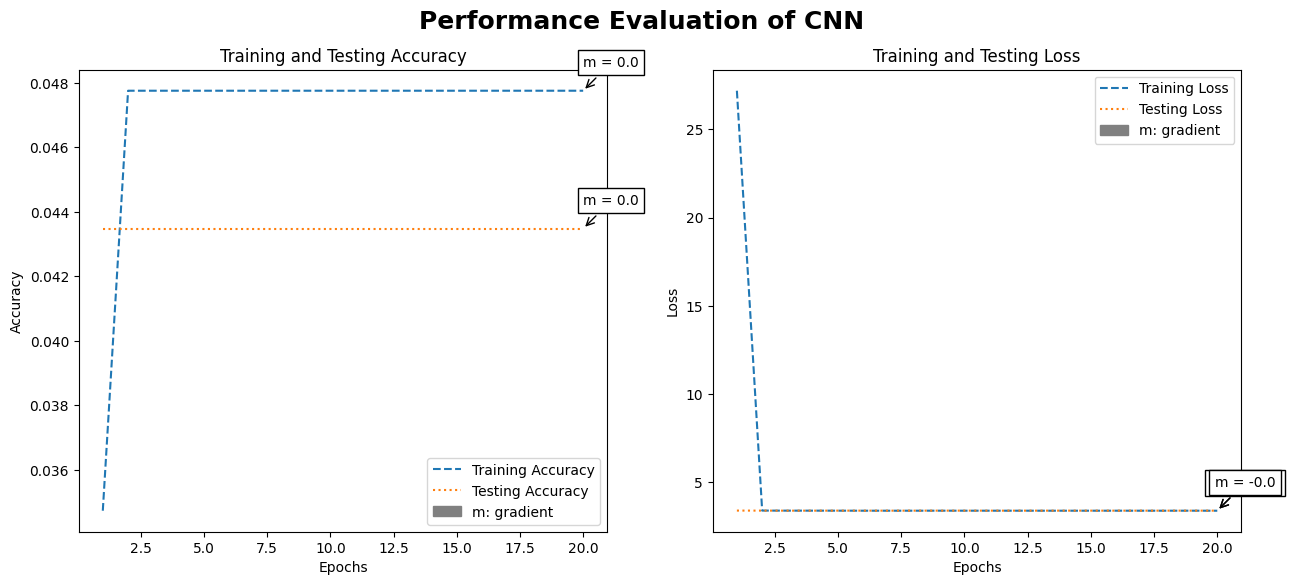

In [ ]:
# visualizing the evaluation scores as a more readable graph:
def visualize_evaluation(history_dict, model_name):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    epochs = range(1, len(history_dict['accuracy'])+1)

    def get_gradient(y_arr, epochs):
        return round((y_arr[-1] - y_arr[0]) / (epochs[-1] - epochs[0]),2)

    def visualize_sub_evaluation(n, Accuracy, train_acc, val_acc, epochs):
        axs[n].plot(epochs, train_acc, label=f'Training {Accuracy}', ls='--')
        axs[n].plot(epochs, val_acc, label=f'Testing {Accuracy}', ls='dotted')

        axs[n].set_title(f'Training and Testing {Accuracy}')
        axs[n].set_xlabel('Epochs')
        axs[n].set_ylabel(Accuracy)
        
        handles, labels = axs[n].get_legend_handles_labels()
        m_patch = mpatches.Patch(color='grey',label='m: gradient')
        handles.append(m_patch) 
        axs[n].legend(handles=handles)
        
        def annotate_box(train_acc):
            return AnnotationBbox(TextArea(f"m = {get_gradient(train_acc, epochs)}"), (epochs[-1], train_acc[-1]),
                            xybox=(20, 20),
                            xycoords='data',
                            boxcoords="offset points",
                            arrowprops=dict(arrowstyle="->"))
        axs[n].add_artist(annotate_box(train_acc))
        axs[n].add_artist(annotate_box(val_acc))

    train_acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    visualize_sub_evaluation(0, 'Accuracy', train_acc, val_acc, epochs)

    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    visualize_sub_evaluation(1, 'Loss', train_loss, val_loss, epochs)
    
    plt.suptitle(f"Performance Evaluation of {model_name}",fontsize=18, fontweight='bold')
    plt.show()
    
history_dict_first = history_first.history
visualize_evaluation(history_dict_first, 'CNN')

In [ ]:
# Define a Callback class that stops training once accuracy reaches 80%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.80):
            print("\nReached 80% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
            loss = 'sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
history_first = model.fit(train_generator,
                    epochs=10,
                    validation_data=testing_generator,
                    callbacks=callbacks)

Epoch 1/10
22/22 [==============================] - 107s 5s/step - loss: 3.3908 - accuracy: 0.0478 - val_loss: 3.3967 - val_accuracy: 0.0435
Epoch 2/10
22/22 [==============================] - 96s 4s/step - loss: 3.3901 - accuracy: 0.0478 - val_loss: 3.3964 - val_accuracy: 0.0435
Epoch 3/10
22/22 [==============================] - 100s 5s/step - loss: 3.3901 - accuracy: 0.0478 - val_loss: 3.3963 - val_accuracy: 0.0435
Epoch 4/10
22/22 [==============================] - 100s 4s/step - loss: 3.3900 - accuracy: 0.0478 - val_loss: 3.3963 - val_accuracy: 0.0435
Epoch 5/10
22/22 [==============================] - 102s 5s/step - loss: 3.3902 - accuracy: 0.0478 - val_loss: 3.3965 - val_accuracy: 0.0435
Epoch 6/10
22/22 [==============================] - 107s 5s/step - loss: 3.3900 - accuracy: 0.0478 - val_loss: 3.3963 - val_accuracy: 0.0435
Epoch 7/10
22/22 [==============================] - 96s 4s/step - loss: 3.3900 - accuracy: 0.0478 - val_loss: 3.3962 - val_accuracy: 0.0435
Epoch 8/10
22/2

## Analysis and Future Recommendations
In our first iteration of training + testing, we used the hyperparameters of: 
- learning rate = 0.01 
- max_epoch = 20
- gamma = 0.95

The gamma value here represents the cut-off at which we stop training one epoch once the accuracy reaches 95 in order to prevent over-training the model. 

In our second iteration, we re-adjusted the hyperparameters a bit as below to see any changes in the performance: 
- learning rate = 0.001 
- max_epoch = 10
- gamma = 0.80

The testing accuracy score for both first and second iterations did not improve even after changing the hyperparameters.

Even after processing our image data with ``ImageDataGenerator``, we still lack image data to train our models, which has a significant impact on the likelihood of our model overfitting. To further fix the overfitting, there are two different ways to go about this:
1. Reimplement our CNN model using a machine learning technique called 'Transfer Learning', which works specifically better with small datasets.
2. Add more image files either from other datasets or on our own before training the model.

Other than improving the overall performance of our CNN model, we'd also like to figure out a way to implement the CNN in PyTorch as originally intended but with some more code that can improve that compatibility with data generators. 

In our machine learning class, another group uptook a project similar to this but they focused their project around vegetables. An interesting idea that they had was to import a picture of our professor to see what type of vegetable their model would classify their professor to be and it turns out that he was a tomato. So we thought that an interesting next step for us would be to take a picture of our professor and see what type of plant our model classifies our professor as. 

## Why image classification? 

On more of a serious side, we decided image classification project is an interesting one to do, because it is everywhere. For example, we see an instance of image classification when you drag an image of anything really onto Google search bar and Google returns the keyword given the image. That is done through a much more complicated version of neural networks! Therefore, we thought that doing a project that touches upon this subject is a nice introduction to something like that.

## Resources

- https://towardsdatascience.com/image-data-augmentation-for-deep-learning-77a87fabd2bf#:~:text=The%20ImageDataGenerator%20class%20allows%20your,of%20images%20that%20you%20have
- PyTorch documentation
- TensorFlow documentation